In [1]:
from mpi4py import MPI
import numpy as np
import pylab as plt

import uvtools
import hera_cal as hc
import pyuvdata
from pyuvdata import UVData

from hera_sim.visibilities import VisCPU, conversions
from hera_sim.beams import PolyBeam, PerturbedPolyBeam

import ultranest

try:
    import healpy
    import healvis
except:
    print("Unable to import healpy and/or healvis; diffuse mode unavailable")

import utils
import time, copy, sys
from numba import jit

# Begin MPI
#if use_mpi:
#    comm = MPI.COMM_WORLD
#    myid = comm.Get_rank()
#else:
#    comm = None
#    myid = 0

/home/phil/.local/lib/python3.7/site-packages/hera_sim-0.3.0-py3.7.egg/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/home/phil/.local/lib/python3.7/site-packages/hera_sim-0.3.0-py3.7.egg/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/home/phil/.local/lib/python3.7/site-packages/hera_sim-0.3.0-py3.7.egg/hera_sim/__init__.py:37: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, c

In [2]:
def default_cfg():
    """
    Set parameter defaults.
    """
    # Simulation specification
    cfg_spec = dict( nfreq=16,
                     start_freq=1.e8,
                     bandwidth=0.2e8,
                     start_time=2458902.33333,
                     integration_time=40.,
                     ntimes=3,
                     cat_name="gleamegc.dat",
                     apply_gains=True,
                     apply_noise=True,
                     ant_pert=False,
                     seed=None,
                     ant_pert_sigma=0.0,
                     use_legacy_array=False,
                     hex_spec=(3,4), 
                     hex_ants_per_row=None, 
                     hex_ant_sep=14.6,
                     use_ptsrc=True )
                        
    # Diffuse model specification
    cfg_diffuse = dict( use_diffuse=False,
                        nside=64,
                        obs_latitude=-30.7215277777,
                        obs_longitude = 21.4283055554,
                        obs_height = 1073,
                        beam_pol='XX',
                        diffuse_model='GSM',
                        eor_random_seed=42,
                        nprocs=1 )
    
    # Beam model parameters
    cfg_beam = dict( ref_freq=1.e8,
                     spindex=-0.6975,
                     seed=None,
                     perturb_scale=0.0,
                     mainlobe_scale=1.0,
                     xstretch=1.0,
                     ystretch=1.0,
                     xystretch_same=True,
                     xystretch_dist=None,
                     rotation_dist='',
                     rotation=0.0,
                     mainlobe_width=0.3, 
                     nmodes=8,
                     beam_coeffs=[ 0.29778665, -0.44821433, 0.27338272, 
                                  -0.10030698, -0.01195859, 0.06063853, 
                                  -0.04593295,  0.0107879,  0.01390283, 
                                  -0.01881641, -0.00177106, 0.01265177, 
                                  -0.00568299, -0.00333975, 0.00452368,
                                   0.00151808, -0.00593812, 0.00351559
                                 ] )
    
    # Fluctuating gain model parameters
    cfg_gain = dict(nmodes=8, seed=None)
    
    # Noise parameters
    cfg_noise = dict(nsamp=1., seed=None, noise_file=None)
    
    # Combine into single dict
    cfg = { 'sim_beam':     cfg_beam,
            'sim_spec':     cfg_spec,
            'sim_diffuse':  cfg_diffuse,
            'sim_noise':    cfg_noise,
            'sim_gain':     cfg_gain,
           }
    return cfg

In [3]:
class VisModel(object):
    
    def __init__(self, uvd_init, 
                 ptsrc_ra_dec, ptsrc_flux,
                 beam_model=PerturbedPolyBeam, 
                 default_beam_params={},
                 free_params_antpos=[], free_params_beam=[], 
                 free_params_ptsrc=[],
                 free_beams=[], free_ants=[], free_ptsrcs=[],
                 verbose=False, comm=None):
        """
        Construct a model for a set of visibility data from a series 
        of data model components. This object handles caching of 
        results to avoid expensive recomputations where possible.
        
        Parameters
        ----------
        uvd_init : UVData object
            UVData object with the correct data shape (number of 
            frequencies, times, polarisations, antennas).
        
        ptsrc_ra_dec, ptsrc_flux : array_like
            Point source position and flux arrays.
        
        beam_model : UVBeam, optional
            Beam model class to be used for the primary beams.
            Default: PerturbedPolyBeam
        
        default_beam_params : dict
            Default values of all beam model parameters.
        
        free_params_antpos, free_params_beam, free_params_ptsrc : lists of str
            Ordered lists of names of parameters to be varied. 
            The ordering maps to the parameter vector.
        
        free_beams, free_ants, free_ptsrcs : list of int
            Ordered list of which beams/antennas/point sources 
            are to have their parameters varied. The ordering 
            maps to the parameter vector.
        
        verbose : bool, optional
            Whether to print debug messages. Default: True.
        
        comm : MPI communicator, optional
            MPI communicator to be passed to simulator. Default: None.
        """
        # Set basic parameters
        assert isinstance(uvd_init, UVData), "uvd_init must be a valid UVData object"
        self.verbose = verbose
        
        # Store basic data object
        self.uvd = copy.deepcopy(uvd_init)
        
        # General settings
        self._freqs = np.unique(self.uvd.freq_array)
        self._ant_index = self.uvd.antenna_numbers
        
        # Initial antenna positions (for antennas with free positions)
        self.antpos_initial = {}
        for ant in free_ants:
            pos = self.uvd.antenna_positions[np.where(self.uvd.antenna_numbers == ant)]
            self.antpos_initial[ant] = pos.flatten()
        
        # Set beam type
        self.BeamClass = beam_model
        self.beams = [[] for i in range(self.uvd.Nants_data)]
        self.default_beam_params = default_beam_params
        
        # Point source catalogue
        self.ptsrc_ra_dec = ptsrc_ra_dec.copy()
        self.ptsrc_flux = ptsrc_flux.copy()
        self.ptsrc_delta_radec = np.zeros(self.ptsrc_ra_dec.shape)
        self.ptsrc_flux_factor = np.ones(self.ptsrc_ra_dec.shape[0])
        
        # Mappings between param vector and param names
        self.free_params_antpos = free_params_antpos
        self.free_params_beam = free_params_beam
        self.free_params_ptsrc = free_params_ptsrc
        self.free_beams = free_beams
        self.free_ants = free_ants
        self.free_ptsrcs = free_ptsrcs
        
        # MPI handling
        self.comm = comm
        
        # Construct beam model with new parameter values
        for i in range(self.uvd.Nants_data):
            self.beams[i] = self.BeamClass(**self.default_beam_params)
        
        # Model visibility:
        #   Antenna positions
        #   Primary beam models
        #   Sky model: point sources
        #   Sky model: Gaussian sources
        #   Sky model: diffuse
    
    
    def set_antpos(self, ant, params):
        """
        Set position parameters of named antenna.
        
        Parameters
        ----------
        ant : int
            Antenna ID.
        
        params : array_like
            Vector of parameters. Names and ordering are defined 
            in `self.free_params_antpos`.
        """
        # Extract antenna position parameters
        vec = np.zeros(3)
        j = 0
        for i, p in enumerate(['antpos_dx', 'antpos_dy', 'antpos_dz']):
            if p in self.free_params_antpos:
                vec[i] = params[j]
                j += 1
        
        # Update antenna positions
        self.uvd.antenna_positions[ant] = self.antpos_initial[ant] + vec
    
    
    def set_beam(self, ant, params):
        """
        Set the parameters of a beam.
        
        Parameters
        ----------
        ant : int
            Antenna ID.
            
        params : array_like
            Vector of parameters. Names and ordering are defined 
            in `self.free_params_beams`.
        """
        assert len(params) == len(self.free_params_beam)
        
        # Copy default parameter values
        param_dict = copy.copy(self.default_beam_params)
        
        # Update parameter values that have changed
        for i, pname in enumerate(self.free_params_beam):
            param_dict[pname] = params[i]
        
        # Construct beam model with new parameter values
        idx = np.where(self._ant_index == ant)[0][0]
        self.beams[idx] = self.BeamClass(**param_dict)
        # First arg is: perturb_coeffs=[0.,]
    
    
    def set_ptsrc_params(self, i, params):
        """
        Set the parameters of a point source.
        
        Parameters
        ----------
        i : int
            Point source index in the catalogue.
            
        params : array_like
            Vector of parameters. Names and ordering are defined 
            in `self.free_params_ptsrcs`.
        """
        # Set point source parameters if specified
        if 'delta_ra' in self.free_params_ptsrc:
            self.ptsrc_delta_radec[i][0] = params[self.free_params_ptsrc.index('delta_ra')]
        if 'delta_dec' in self.free_params_ptsrc:
            self.ptsrc_delta_radec[i][1] = params[self.free_params_ptsrc.index('delta_dec')]
        if 'flux_factor' in self.free_params_ptsrc:
            self.ptsrc_flux_factor[i] = params[self.free_params_ptsrc.index('flux_factor')]
    
    
    def param_names(self):
        """
        Return list of parameter names in order.
        """
        pnames = []
        
        # Antenna position parameters
        for ant in self.free_ants:
            for p in self.free_params_antpos:
                pnames.append("%s_%03d" % (p, ant))
        
        # Beam parameters
        for ant in self.free_beams:
            for p in self.free_params_beam:
                pnames.append("%s_%03d" % (p, ant))
        
        # Point source parameters
        for i in self.free_ptsrcs:
            for p in self.free_params_ptsrc:
                pnames.append("%s_%06d" % (p, i))
        
        return pnames
    
    
    def simulate(self):
        """
        Simulate visibilities for the current state of the model.
        """
        # Need to zero the array, which is usually returned by 
        # reference rather than copied
        self.uvd.data_array *= 0.
        
        # Construct new simulator class with updated settings
        simulator = VisCPU(
            uvdata=self.uvd,                          # fixed
            beams=self.beams,                         # varies
            beam_ids=self._ant_index,                 # fixed
            sky_freqs=self._freqs,                    # fixed
            point_source_pos=self.ptsrc_ra_dec + self.ptsrc_delta_radec, # varies
            point_source_flux=self.ptsrc_flux * self.ptsrc_flux_factor,  # varies
            precision=2,                              # fixed
            use_pixel_beams=False, # Do not use pixel beams
            bm_pix=10,
            mpi_comm=self.comm
        )
        
        # Run simulation
        if self.verbose:
            print("  Beginning simulation")
        tstart = time.time()
        simulator.simulate()
        if self.verbose:
            print("  Simulation took %2.1f sec" % (time.time() - tstart))
    
        #if myid != 0:
        #    # Wait for root worker to finish IO before ending all other worker procs
        #    comm.Barrier()
        #    sys.exit(0)
        
        return simulator.uvdata
    
    
    def model(self, params):
        """
        Calculate model visibilities for a given parameter vector.
        
        Parameters
        ----------
        params : array_like
            Vector of parameter values. The number of parameters 
            and position of each parameter in the vector must 
            follow the specification 
        """
        params = np.array(params)
        
        # Count free parameters and antennas/beams
        Nfree_ants = len(self.free_ants)
        Nfree_beams = len(self.free_beams)
        Nfree_ptsrcs = len(self.free_ptsrcs)
        Nparams_ants = len(self.free_params_antpos)
        Nparams_beams = len(self.free_params_beam)
        Nparams_ptsrcs = len(self.free_params_ptsrc)
        
        # Extract parameters in blocks and reshape
        iants = Nfree_ants * Nparams_ants
        ibeams = Nfree_beams * Nparams_beams
        iptsrcs = Nfree_ptsrcs * Nparams_ptsrcs
        antpos_params = params[0:iants].reshape((Nfree_ants, Nparams_ants))
        beam_params = params[iants:iants+ibeams].reshape((Nfree_beams, Nparams_beams))
        ptsrc_params = params[iants+ibeams:iants+ibeams+iptsrcs].reshape((Nfree_ptsrcs, Nparams_ptsrcs))
        
        # (1) Antenna positions
        for i, ant in enumerate(self.free_ants):
            self.set_antpos(ant, antpos_params[i])
        
        # (2) Beam parameters
        for i, ant in enumerate(self.free_beams):
            self.set_beam(ant, beam_params[i])
        
        # (3) Point source parameters
        for i in self.free_ptsrcs:
            self.set_ptsrc_params(i, ptsrc_params[i])
        
        # Run simulation
        _uvd = self.simulate()
        self.uvd = _uvd
        return _uvd

In [4]:
# Load template configuration
cfg = default_cfg()
cfg_spec = cfg['sim_spec']

# Initialise shape of data and antenna array
ants = utils.build_hex_array(hex_spec=cfg_spec['hex_spec'], 
                             ants_per_row=cfg_spec['hex_ants_per_row'], 
                             d=cfg_spec['hex_ant_sep'])
uvd_init = utils.empty_uvdata(ants=ants, **cfg_spec)

# Point source catalogue
ra_dec, flux = utils.load_ptsrc_catalog('../non-redundant-pipeline/catBC.txt', 
                                        freq0=100e6, freqs=np.unique(uvd_init.freq_array), 
                                        usecols=(0,1,2,3))

## Likelihood and sampling

In [5]:
class VisLike(object):
    """
    Manage likelihood calculations for a set of visibility data.
    """
    
    def __init__(self, data, model, var):
        """
        Object to handle likelihood evaluation.
        
        Parameters
        ----------
        data : UVData object
            Object containing data.
        
        model : VisModel object
            Object containing model spec.
        
        var : float
            Noise variance. For now, this is just a constant float.
        """
        assert isinstance(data, UVData), "data must be an instance of UVData"
        assert isinstance(model, VisModel), "model must be an instance of VisModel"
        self.data = data
        self.model = model
        self.var = var
        
        # Validate shape of data and model
        self.validate()
    
    
    def prior_cube(self, cube, init_vals):
        """
        Return prior in the form of a cube for ultranest.
        """
        trans_params = np.empty_like(cube)
        
        pnames = self.model.param_names()
        for i, pn in enumerate(pnames):
            
            # Antenna positions
            if 'antpos_dx' in pn or 'antpos_dy' in pn or 'antpos_dz' in pn:
                vmin = init_vals[i] - 0.02
                vmax = init_vals[i] + 0.02
                trans_params[i] = vmin + (vmax - vmin) * cube[i] # Uniform distribution
            
            # Beam parameters
            if 'mainlobe_scale' in pn:
                vmin = 0.95
                vmax = 1.05
                trans_params[i] = vmin + (vmax - vmin) * cube[i] # Uniform distribution
            
        return trans_params
    
    
    def validate(self):
        """
        Check that data and model have the same shape.
        """
        assert self.model.uvd.data_array.shape == self.data.data_array.shape, \
            "Model and data have different shape"
    
    
    def logl(self, params):
        """
        Calculate the log-likelihood.
        """
        model = self.model.model(params)
        flags = ~self.data.flag_array
        logl = -0.5 * flags*np.abs(self.data.data_array - model.data_array)**2. / self.var \
               -0.5 * np.log(2.*np.pi*self.var) * self.data.data_array.size
        return np.sum(logl)

# Fisher matrix

In [ ]:
def gain_deriv():
    """
    Calculate the derivative of a visibility with respect to the 
    complex gain for a given antenna, time, and frequency sample.
    """
    
    

In [6]:
def calc_fisher(model, fiducial, var=1., dx=0.01, verbose=True):
    """
    Calculate Fisher matrix from a model.
    
    Parameters
    ----------
    model : VisModel object
        Contains model spec.
    
    fiducial : array_like
        Fiducial vector of model parameters, in the 
        same ordering as `model.param_names()`.
    
    var : array_like, optional
        Vector of variance values, either a scalar or as an 
        array with the same shape as the data.
        Default: 1.
    
    dx : float, optional
        Finite difference for all parameters. Default: 0.01.
    
    verbose : bool, optional
        Whether to print debug messages. Default: True.
    
    Returns
    -------
    fisher : array_like
        Fisher matrix.
    """
    pnames = model.param_names()
    assert len(pnames) == len(fiducial), \
        "Fiducial parameter vector has different size to expected number of parameters"
    
    # Fisher matrix and fiducial parameter vector
    F = np.zeros((len(pnames), len(pnames)))
    fid = fiducial.copy()
    
    # Loop over parameters
    for i in range(len(pnames)):
        if verbose:
            print("%d / %d" % (i, len(pnames)))

        # i derivative
        vmi = fid.copy()
        vpi = fid.copy()
        vmi[i] = vmi[i] - dx
        vpi[i] = vpi[i] + dx
        model_p = model.model(vpi).copy()
        model_m = model.model(vmi).copy()
        dmodel_dxi = (model_p.data_array - model_m.data_array) / (2.*dx)

        for j in range(i, len(pnames)):

            # j derivative
            vmj, vpj = fid.copy(), fid.copy()
            vmj[j] -= dx
            vpj[j] += dx
            model_pj = model.model(vpj).copy()
            model_mj = model.model(vmj).copy()
            dmodel_dxj = (model_pj.data_array - model_mj.data_array) / (2.*dx)

            # Calculate Fisher matrix element
            F[i,j] = F[j,i] = np.sum( (dmodel_dxi.real * dmodel_dxj.real + dmodel_dxi.imag * dmodel_dxj.imag) / var )
    
    return F

In [7]:
def calc_fisher_bigmem(model, fiducial, var=1., dx=0.01, verbose=True):
    """
    Calculate Fisher matrix from a model. Stores the derivatives 
    in memory for faster computation (but uses much more memory).
    
    Parameters
    ----------
    model : VisModel object
        Contains model spec.
    
    fiducial : array_like
        Fiducial vector of model parameters, in the 
        same ordering as `model.param_names()`.
    
    var : array_like, optional
        Vector of variance values, either a scalar or as an 
        array with the same shape as the data.
        Default: 1.
    
    dx : float, optional
        Finite difference for all parameters. Default: 0.01.
    
    verbose : bool, optional
        Whether to print debug messages. Default: True.
    
    Returns
    -------
    fisher : array_like
        Fisher matrix.
    """
    pnames = model.param_names()
    assert len(pnames) == len(fiducial), \
        "Fiducial parameter vector has different size to expected number of parameters"
    
    # Fisher matrix and fiducial parameter vector
    F = np.zeros((len(pnames), len(pnames)))
    fid = fiducial.copy()
    dmodel_dx = []
    
    # Loop over parameters to get derivatives
    for i in range(len(pnames)):
        if verbose:
            print("%d / %d" % (i, len(pnames)))

        # i derivative
        vmi = fid.copy()
        vpi = fid.copy()
        vmi[i] = vmi[i] - dx
        vpi[i] = vpi[i] + dx
        model_p = model.model(vpi).copy()
        model_m = model.model(vmi).copy()
        dmodel_dxi = (model_p.data_array - model_m.data_array) / (2.*dx)
        dmodel_dx.append(dmodel_dxi)
    
    # Loop over pairs of derivatives to calculate Fisher matrix
    for i in range(len(pnames)):
        dmodel_dxi = dmodel_dx[i]
        for j in range(i, len(pnames)):
            dmodel_dxj = dmodel_dx[j]

            # Calculate Fisher matrix element
            F[i,j] = F[j,i] = np.sum( (dmodel_dxi.real * dmodel_dxj.real + dmodel_dxi.imag * dmodel_dxj.imag) / var )
    
    return F

In [8]:
def fisher_prior(pnames, priors):
    """
    Return Fisher matrix prior for a set of parameters of 
    different types.
    
    Parameters
    ----------
    pnames : list of str
        Ordered list of parameter names.
    
    priors : dict of float
        Dictionary containing sigma values for each 
        type of parameter.
    
    Returns
    -------
    Fprior : array_like
        Prior Fisher matrix.
    """
    Fprior = np.zeros((len(pnames), len(pnames)))
    sigma_vals = np.zeros(len(pnames))
    
    # Loop over parameter types
    for i in range(sigma_vals.size):
        for key in priors.keys():
            if key in pnames[i]:
                sigma_vals[i] = priors[key]
    
    # Put into prior matrix
    Fprior[np.diag_indices(Fprior.shape[0])] = 1. / sigma_vals**2.
    return Fprior

In [9]:
def corrmat(m):
    rho = np.zeros(m.shape)
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            rho[i,j] = m[i,j] / np.sqrt(m[i,i]*m[j,j])
    return rho

# Initialisation

In [10]:
def construct_initial_vector(config, free_params):
    """
    
    Parameters
    ----------
    config : dict
        Dictionary containing initial and default parameters.
    
    free_params : list of str
        List of parameter names (ordered), for parameters 
        that will be varied.
    
    Returns
    -------
    vec : array_like
        Vector of parameter values for parameters that will 
        be varied.
    """
    return np.array([config[p] for p in free_params])

In [11]:
# Load template configuration
cfgX = default_cfg()
cfg_specX = cfgX['sim_spec']

cfg_specX['ntimes'] = 3
Nfree_ptsrc = 50

# Initialise shape of data and antenna array
antsX = utils.build_hex_array(hex_spec=cfg_specX['hex_spec'], 
                              ants_per_row=cfg_specX['hex_ants_per_row'], 
                              d=cfg_specX['hex_ant_sep'])
uvd_initX = utils.empty_uvdata(ants=antsX, **cfg_specX)        

modelX = VisModel(uvd_initX, 
                  ra_dec[:100], flux[:,:100],
                  beam_model=PerturbedPolyBeam, 
                  default_beam_params=cfgX['sim_beam'],
                  free_params_antpos=['antpos_dx', 'antpos_dy', 'antpos_dz'],
                  free_params_beam=['xstretch', 'ystretch', 'spectral_index'], # 'mainlobe_scale'
                  free_params_ptsrc=['delta_ra', 'delta_dec', 'flux_factor'],
                  free_beams=np.arange(10),
                  free_ants=np.arange(10),
                  free_ptsrcs=np.arange(Nfree_ptsrc),
                  comm=None)

# Initial values
init_beamsX = np.ones(3*10)
init_beamsX[2::3] *= -0.6975

init_antposX = np.zeros(3*10)
init_ptsrcX = np.array([0.,0.,1.]*Nfree_ptsrc)

# Combine into initial parameter vector
pnamesX = modelX.param_names()
init_valsX = np.concatenate((init_antposX, init_beamsX, init_ptsrcX))
print(init_valsX)
print(modelX.param_names())

FX = calc_fisher_bigmem(modelX, init_valsX, dx=0.005, verbose=True)

[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      1.      1.     -0.6975  1.      1.     -0.6975
  1.      1.     -0.6975  1.      1.     -0.6975  1.      1.     -0.6975
  1.      1.     -0.6975  1.      1.     -0.6975  1.      1.     -0.6975
  1.      1.     -0.6975  1.      1.     -0.6975  0.      0.      1.
  0.      0.      1.      0.      0.      1.      0.      0.      1.
  0.      0.      1.      0.      0.      1.      0.      0.      1.
  0.      0.      1.      0.      0.      1.      0.      0.      1.
  0.      0.      1.      0.      0.      1.      0.      0.      1.
  0.      0.      1.      0.      0.      1.      0.      0.      1.
  0.      0.      1.      0.      0.      1.      0.      0.      1.
  0.      0.      1.      0.      0.      1.      0.      0.      1.
  0.      0.      1.  

In [12]:
# Build Fisher prior
priorsX = {
    'antpos_dx':        0.05,
    'antpos_dy':        0.05,
    'antpos_dz':        0.05,
    'mainlobe_scale':  0.10,
    'xstretch':        0.10,
    'ystretch':        0.10,
    'spectral_index':  0.10,
    'delta_ra':        0.10,
    'delta_dec':       0.10,
    'flux_factor':     0.05,
}

FpriorX = fisher_prior(pnamesX, priorsX)
print(np.diag(FpriorX))

[400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400. 400. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 400. 100. 100. 400. 100. 100. 400. 100.
 100. 400. 100. 100. 400. 100. 100. 400. 100. 100. 400. 100. 100. 400.
 100. 100. 400. 100. 100. 400. 100. 100. 400. 100. 100. 400. 100. 100.
 400. 100. 100. 400. 100. 100. 400. 100. 100. 400. 100. 100. 400. 100.
 100. 400. 100. 100. 400. 100. 100. 400. 100. 100. 400. 100. 100. 400.
 100. 100. 400. 100. 100. 400. 100. 100. 400. 100. 100. 400. 100. 100.
 400. 100. 100. 400. 100. 100. 400. 100. 100. 400. 100. 100. 400. 100.
 100. 400. 100. 100. 400. 100. 100. 400. 100. 100. 400. 100. 100. 400.
 100. 100. 400. 100. 100. 400. 100. 100. 400. 100. 100. 400. 100. 100.
 400. 100. 100. 400. 100. 100. 400. 100. 100. 400. 100. 100. 400. 100.
 100. 

In [13]:
pnamesX = modelX.param_names()
sigmaX = np.sqrt(np.diag(np.linalg.pinv(FX + FpriorX)))
for i in range(init_valsX.size):
    print("%30s  %+12.6f +/- %8.6f" % (pnamesX[i], init_valsX[i], sigmaX[i]))

                 antpos_dx_000     +0.000000 +/- 0.031786
                 antpos_dy_000     +0.000000 +/- 0.041226
                 antpos_dz_000     +0.000000 +/- 0.035926
                 antpos_dx_001     +0.000000 +/- 0.031764
                 antpos_dy_001     +0.000000 +/- 0.041469
                 antpos_dz_001     +0.000000 +/- 0.035095
                 antpos_dx_002     +0.000000 +/- 0.032068
                 antpos_dy_002     +0.000000 +/- 0.042025
                 antpos_dz_002     +0.000000 +/- 0.036058
                 antpos_dx_003     +0.000000 +/- 0.032093
                 antpos_dy_003     +0.000000 +/- 0.041531
                 antpos_dz_003     +0.000000 +/- 0.036424
                 antpos_dx_004     +0.000000 +/- 0.031423
                 antpos_dy_004     +0.000000 +/- 0.039154
                 antpos_dz_004     +0.000000 +/- 0.034726
                 antpos_dx_005     +0.000000 +/- 0.031423
                 antpos_dy_005     +0.000000 +/- 0.039154
              

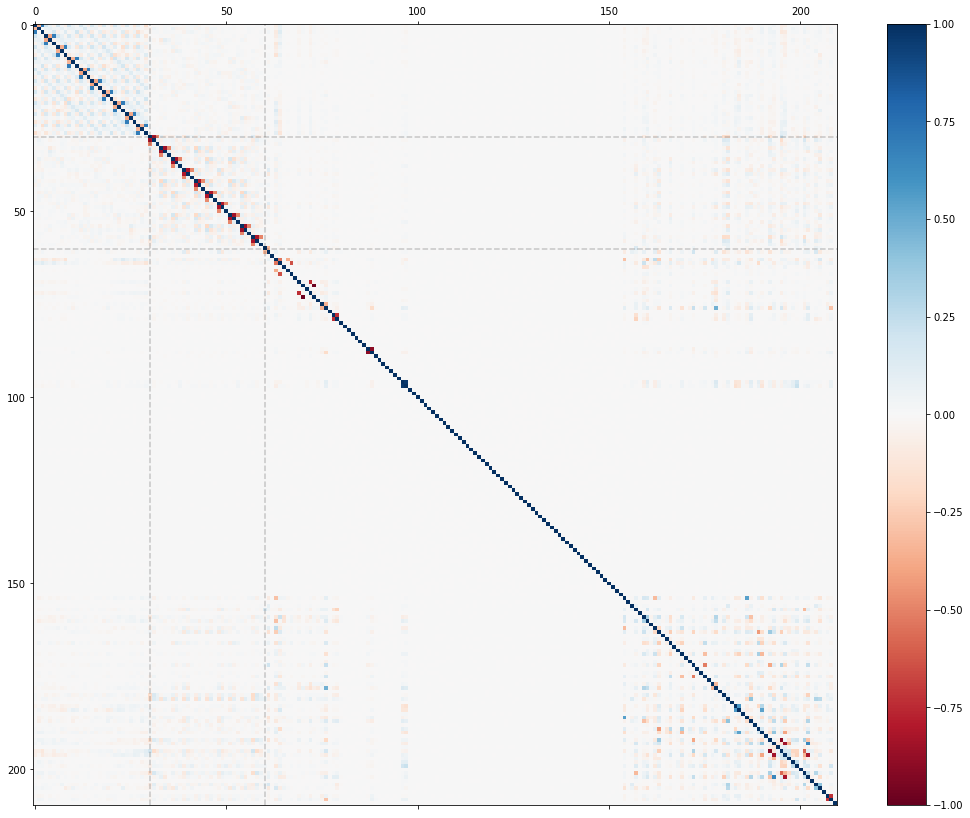

In [14]:
plt.matshow(corrmat(np.linalg.pinv(FX + FpriorX)), aspect='auto', vmin=-1., vmax=1., cmap='RdBu')

# Plot dividing lines for blocks of parameters
for i in [3*10, 3*10+3*10]:
    plt.axhline(i, color='k', ls='dashed', alpha=0.2)
    plt.axvline(i, color='k', ls='dashed', alpha=0.2)
plt.colorbar()
plt.gcf().set_size_inches((18., 14.))

Casting complex values to real discards the imaginary part


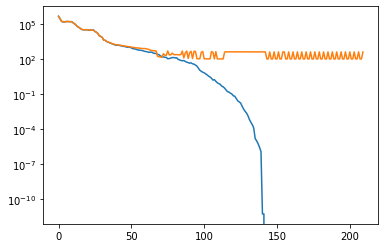

In [15]:
plt.plot(np.linalg.eigvals(FX))
plt.plot(np.linalg.eigvals(FX + FpriorX))
plt.axhline(0., color='k', ls='dashed')
plt.yscale('log')

xstretch_000 0.018734726823678185
ystretch_000 0.023911330311037423
xstretch_001 0.020788989722159562
ystretch_001 0.0264208264841153
xstretch_002 0.019987607061578098
ystretch_002 0.025373467380395844
xstretch_003 0.01789473008563562
ystretch_003 0.0225291875303076
xstretch_004 0.018137821903744567
ystretch_004 0.02283896670333783
xstretch_005 0.018137821903744408
ystretch_005 0.022838966703337897
xstretch_006 0.01789473008563547
ystretch_006 0.02252918753030772
xstretch_007 0.019987607061578344
ystretch_007 0.025373467380395805
xstretch_008 0.020788989722159458
ystretch_008 0.026420826484114972
xstretch_009 0.018734726823678015
ystretch_009 0.023911330311037184


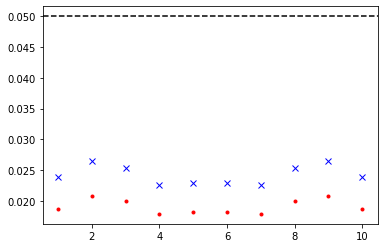

In [16]:
covX = np.linalg.pinv(FX + FpriorX)
j = 0
k = 0
for i, p in enumerate(pnamesX):
    if 'xstretch' in p:
        print(p, np.sqrt(covX[i,i]))
        j += 1.
        plt.plot(j, np.sqrt(covX[i,i]), 'r.')
    
    if 'ystretch' in p:
        print(p, np.sqrt(covX[i,i]))
        k += 1.
        plt.plot(k, np.sqrt(covX[i,i]), 'bx')
plt.axhline(0.05, color='k', ls='dashed')